In [13]:
import numpy as np
import gensim
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import re
import statsmodels.formula.api
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression as lr
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
execfile("./FairAI.py")
%matplotlib nbagg

## Protected Groups

Race,
Color,
Religion or creed,
National origin or ancestry,
Sex,
Age,
Physical or mental disability,
Veteran status,
Genetic information,
Citizenship

In [14]:
nationalities=[
'German',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'French',
'Scottish',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'Filipino'
]

In [15]:
races =[ 
    'Zionist',
    'Catholic',
    'Christian',
    'Islamic',
    'Protestant',
    'Taoist',
    'Atheist',
    'Hindu',
    'Buddhist',
    'Diasporic',
    'Sikh',
    'Juche',
    'Jewish',
    'Bahai',
    'Jains',
    'Shintoist',
    'Paganist',
]

## build toxic words

In [16]:
### hack to overwrite lib method
def words_to_toxicity(model,embeddings,words):
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        vector = np.mean(embeddings[words],axis = 0)
        prob = model.predict_proba([vector])
        return prob[0][0]
    else: return 0;

In [17]:
### try out different word embeddings to compare relative toxicity
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '../data/glove.6B/glove.6B.300d.txt'
word2vec_output_file = '../data/glove.6B/glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)

In [18]:
pos_words = load_lexicon("../data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("../data/opinion_lexicon/negative-words.txt")

## train LR with word embeddings from GLOVE

In [19]:
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors] + [-1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
model = lr(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors, train_targets)
preds =model.predict(test_vectors)
print (preds == test_targets).mean()

0.907051282051282


In [20]:
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors] + [-1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
model = lr(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors, train_targets)
preds =model.predict(test_vectors)
print (preds == test_targets).mean()

0.907051282051282


## Try with 2 different Kernels

In [21]:
model_kernel = svm.SVC(kernel='linear',random_state=0, probability=True).fit(train_vectors, train_targets)
preds =model_kernel.predict(test_vectors)
print (preds == test_targets).mean()
model = svm.SVC(kernel='rbf',random_state=0, probability=True).fit(train_vectors, train_targets)
preds =model.predict(test_vectors)
print (preds == test_targets).mean()

0.907051282051282


/home/csweeney/.local/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9134615384615384


## test sentiment prediction

In [22]:
op =[]
for i,j in enumerate(nationalities):
    
        op.append('i love '+ j + ' food')

In [23]:
text_to_toxicity(model,embeddings,"bad")#,text_to_toxicity(model_kernel,embeddings,'i love african_american food')

0.9992012773467879

## create identity keyword toxicity histograms

In [24]:
dict(identity_toxicity_table(op, embeddings,model_kernel))

{'i love american food': 0.1758775114080027,
 'i love chinese food': 0.09967077394952283,
 'i love dutch food': 0.13491836429148396,
 'i love english food': 0.12104834940514447,
 'i love filipino food': 0.10144907523140007,
 'i love french food': 0.1280407039449572,
 'i love german food': 0.11185365419411955,
 'i love indian food': 0.18020331496577663,
 'i love irish food': 0.12128627808880739,
 'i love italian food': 0.09163816746960085,
 'i love mexican food': 0.16897472415168946,
 'i love norwegian food': 0.1379333200159281,
 'i love russian food': 0.19108522714988763,
 'i love scottish food': 0.09063981629423999,
 'i love swedish food': 0.1065886383814264}

kl divergence from uniform dist for concept net: 0.029834688112972976
kl divergence from uniform dist for google news: 0.05831326507399774


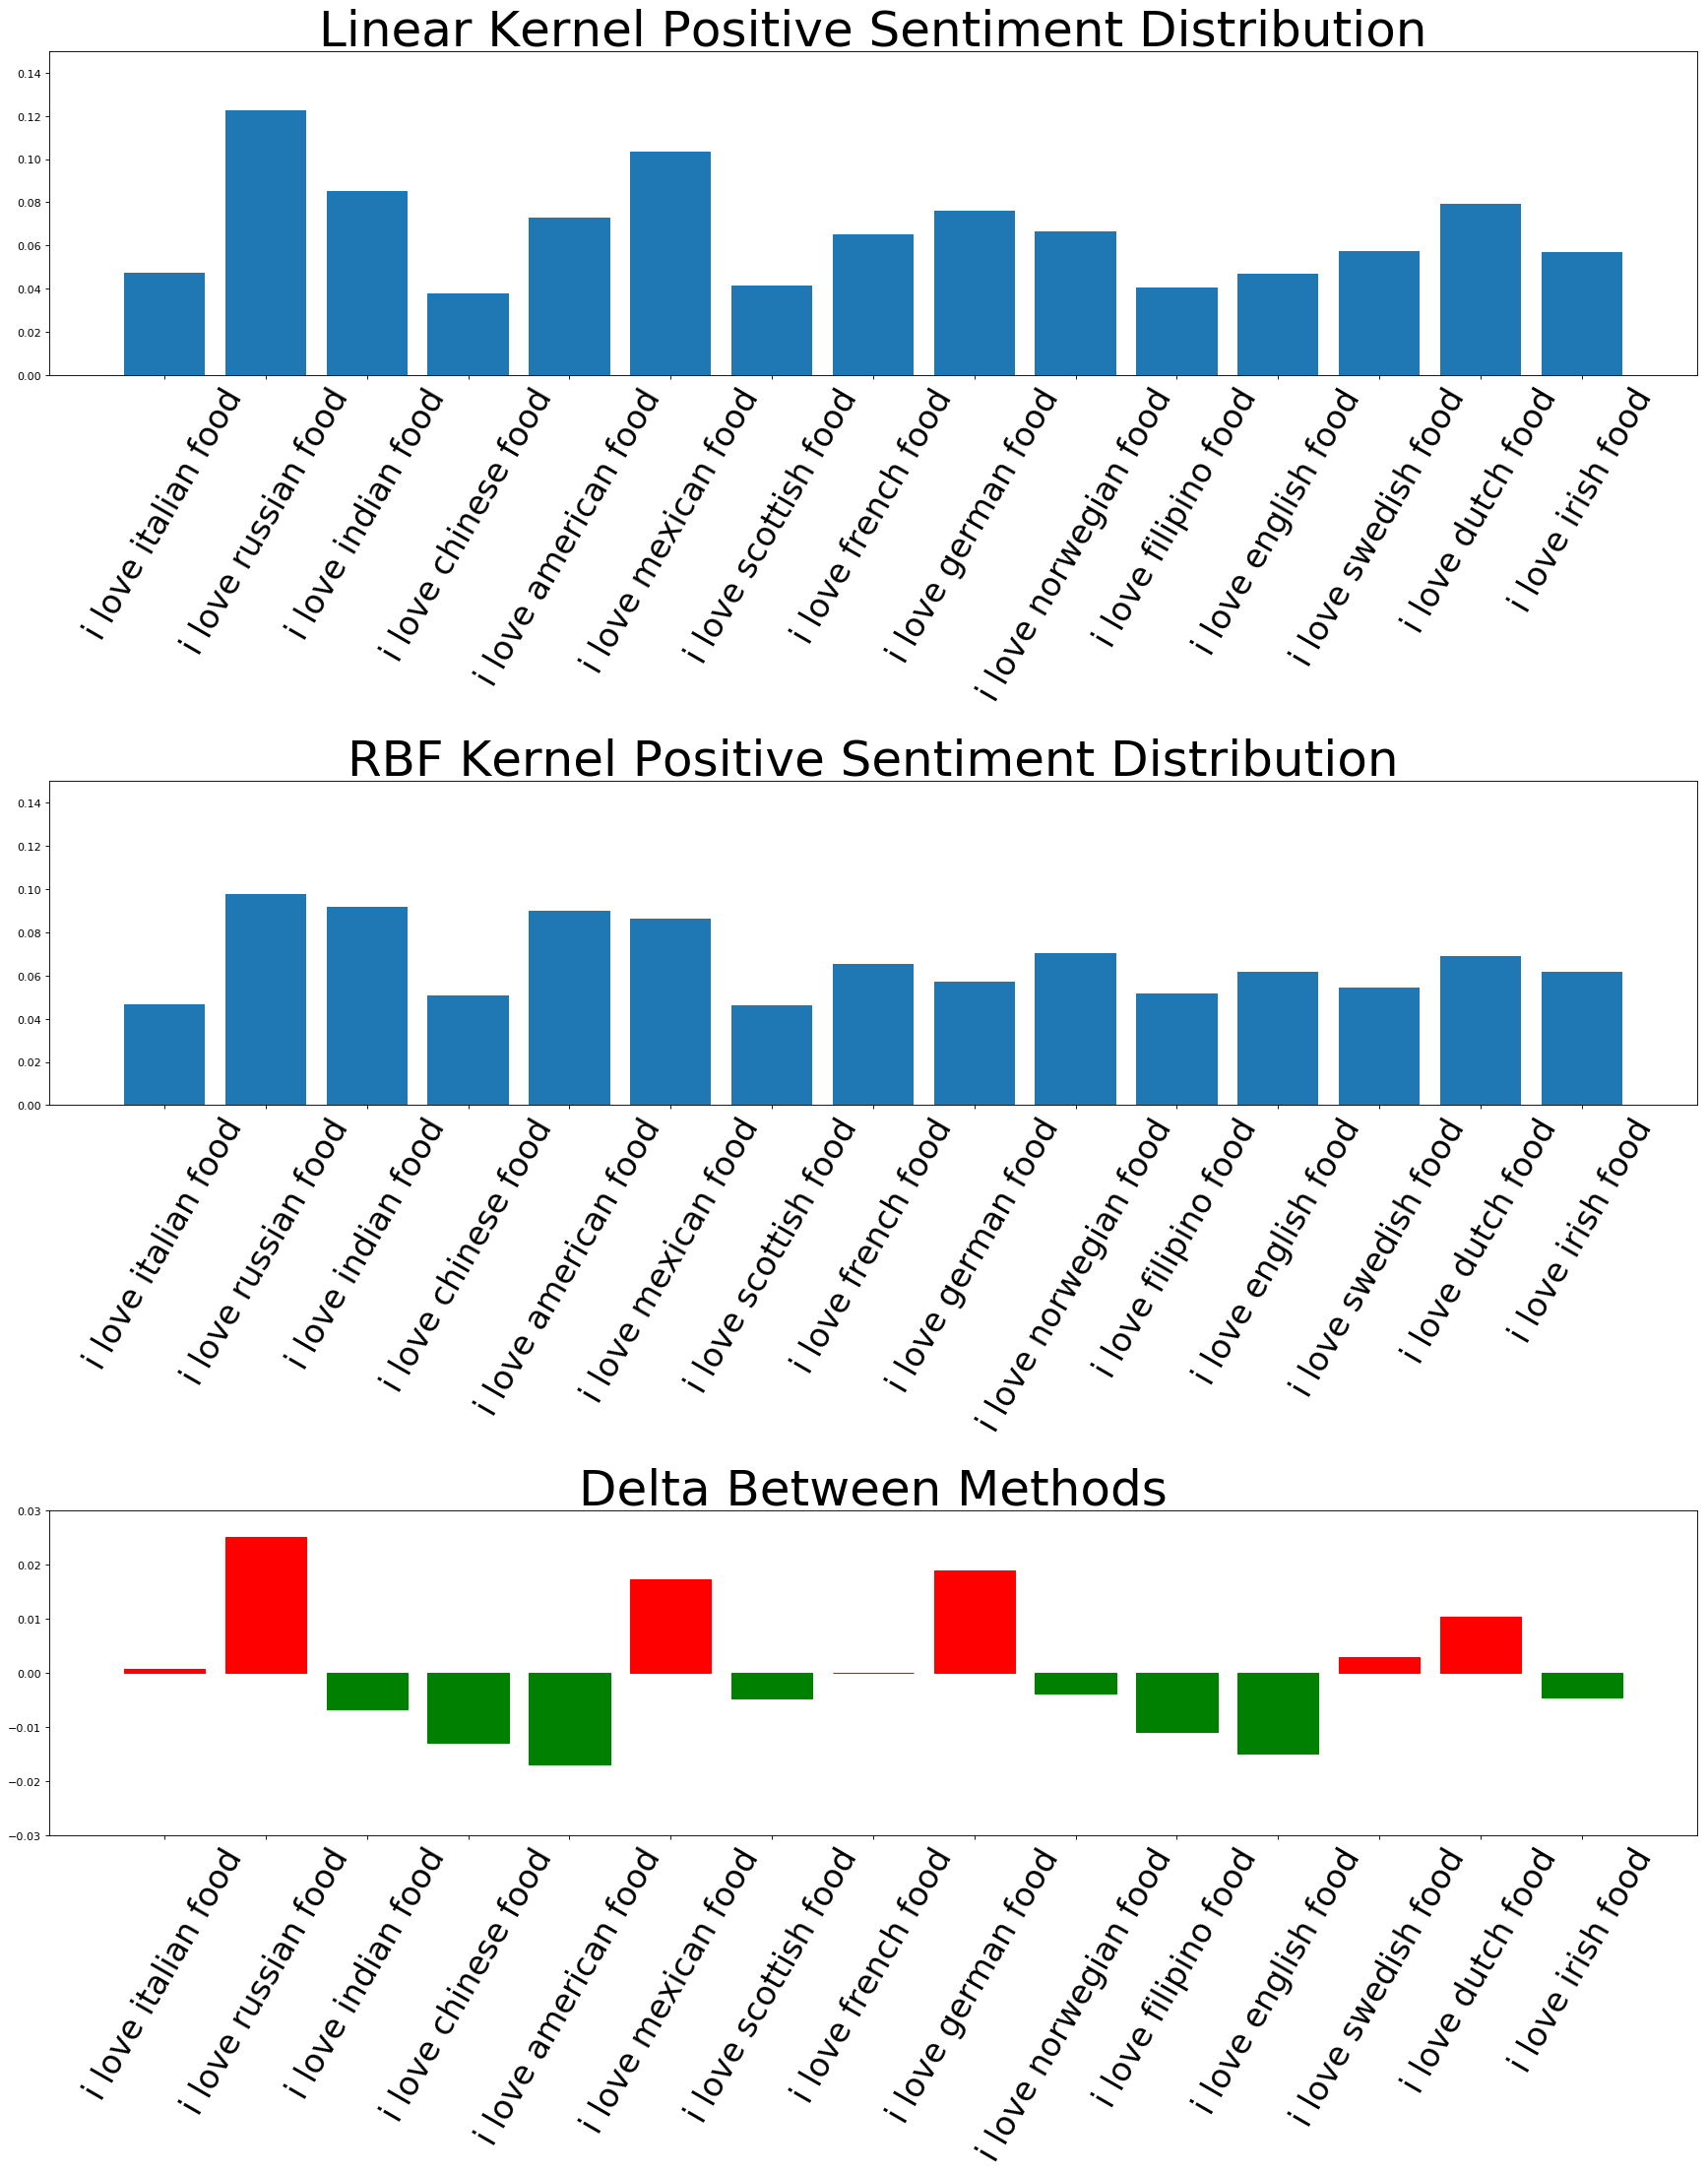

In [25]:
identity_toxicity_debias = dict(identity_toxicity_table(op, embeddings,model_kernel))
identity_toxicity = dict(identity_toxicity_table(op,embeddings,model))
identity_toxicity_debias = (identity_toxicity_debias.keys(),identity_toxicity_debias.values())
identity_toxicity = (identity_toxicity.keys(),identity_toxicity.values())
%matplotlib inline
f = plt.figure(figsize=(27, 30), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=1.25)
f.add_subplot(311)
plt.title("Linear Kernel Positive Sentiment Distribution",fontsize=45)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=30, rotation=60)
plt.ylim(top=.15,bottom=0)
f.add_subplot(312)
plt.title("RBF Kernel Positive Sentiment Distribution",fontsize=45)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=30, rotation=60)
plt.ylim(top=.15,bottom=0)
f.add_subplot(313)
plt.title("Delta Between Methods",fontsize=45)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('g') if j<0 else bar[i].set_color('r')
plt.xticks(index, identity_toxicity_debias[0], fontsize=30, rotation=60)
plt.ylim(top=.03,bottom=-.03)

uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

In [26]:
zip(*sorted(identity_toxicity_table(op,embeddings,model),key=lambda x: x[1]))[0]

('i love chinese food',
 'i love filipino food',
 'i love scottish food',
 'i love english food',
 'i love italian food',
 'i love irish food',
 'i love swedish food',
 'i love french food',
 'i love norwegian food',
 'i love american food',
 'i love german food',
 'i love dutch food',
 'i love indian food',
 'i love mexican food',
 'i love russian food')

kl divergence from uniform dist for concept net: 0.029834688112972945
kl divergence from uniform dist for google news: 0.05831326507399798


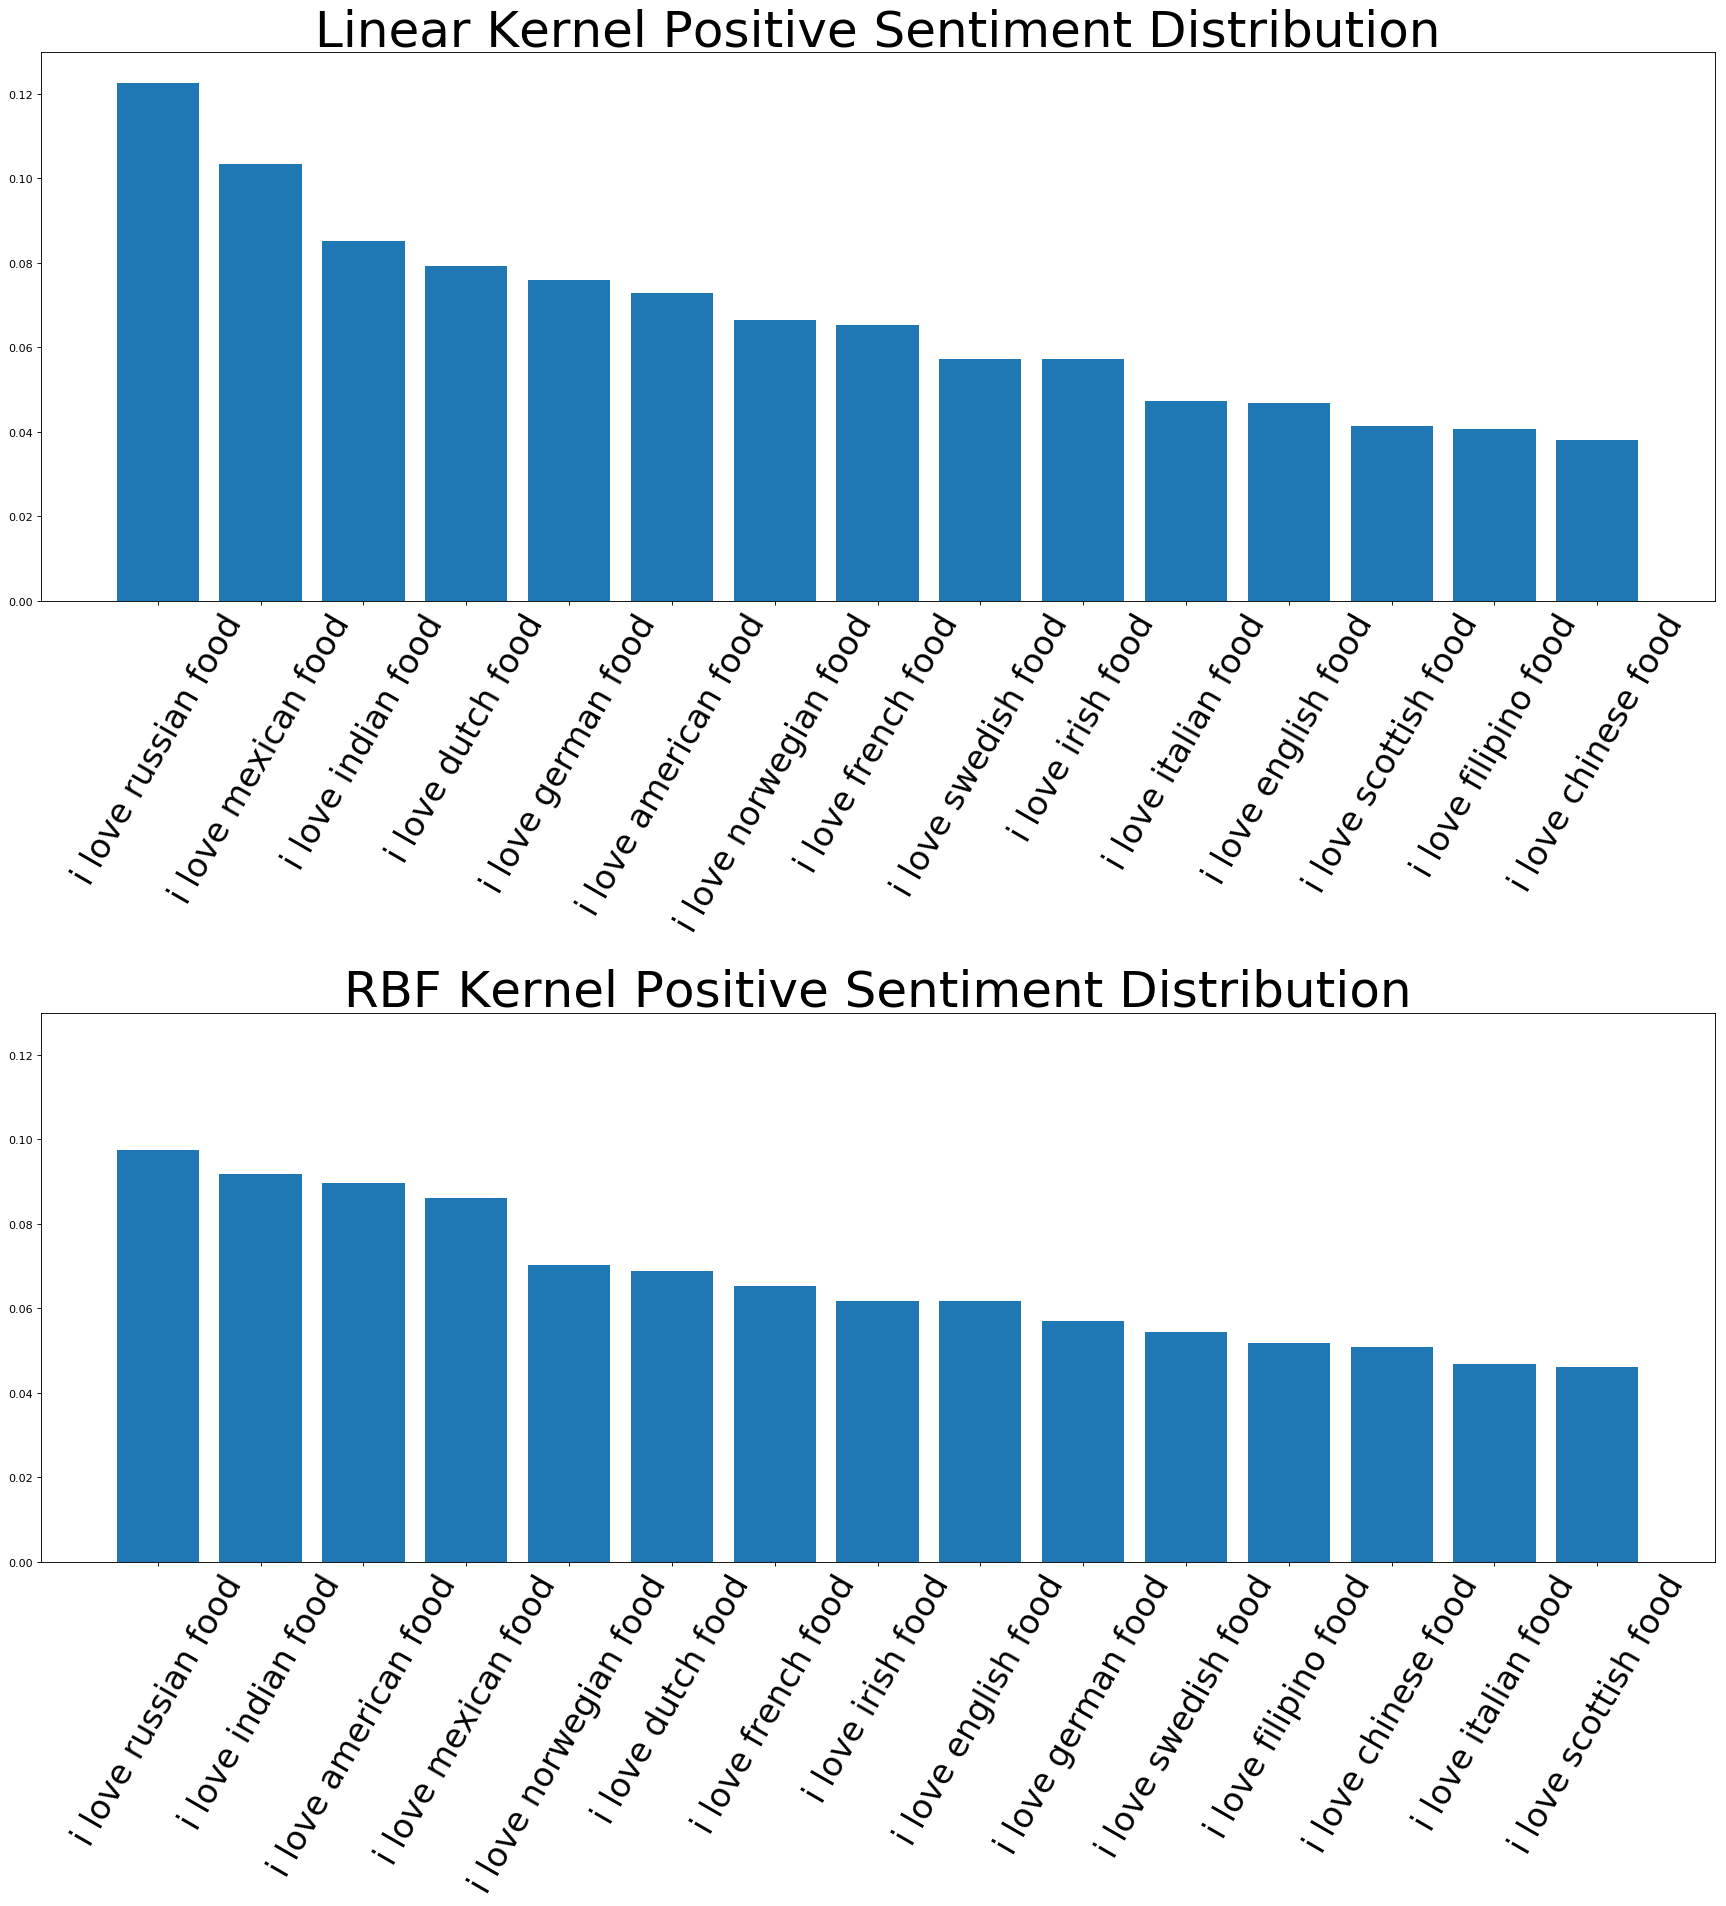

In [27]:
identity_toxicity_debias = zip(*sorted(identity_toxicity_table(op, embeddings,model_kernel),key =lambda x: x[1],reverse=True))
identity_toxicity = zip(*sorted(identity_toxicity_table(op,embeddings,model),key=lambda x: x[1],reverse=True))
# identity_toxicity_debias = (identity_toxicity_debias.keys(),identity_toxicity_debias.values())
# identity_toxicity = (identity_toxicity.keys(),identity_toxicity.values())
%matplotlib inline
f = plt.figure(figsize=(27, 25), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=.75)
f.add_subplot(211)
plt.title("Linear Kernel Positive Sentiment Distribution",fontsize=45)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=30, rotation=60)
plt.ylim(top=.13,bottom=0)
f.add_subplot(212)
plt.title("RBF Kernel Positive Sentiment Distribution",fontsize=45)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=30, rotation=60)
plt.ylim(top=.13,bottom=0)


uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

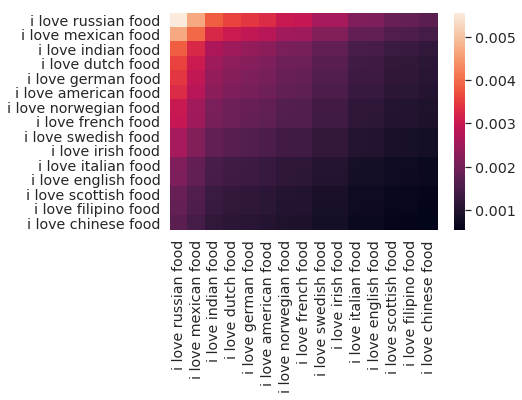

In [28]:
from pandas import DataFrame
import seaborn as sns
sns.set(font_scale=1.3)
%matplotlib inline
A = np.outer(identity_toxicity[1],identity_toxicity[1])
df = DataFrame(A, index=identity_toxicity[0], columns=identity_toxicity[0])
sns.heatmap(df, annot=False)

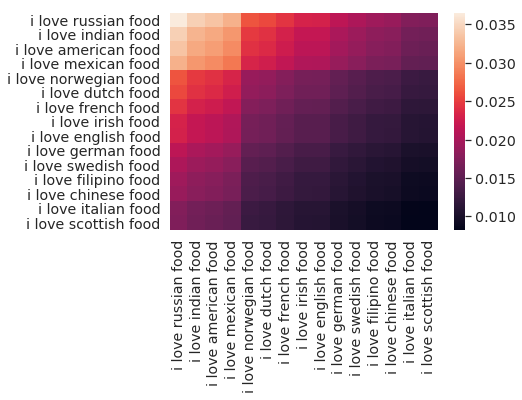

In [30]:
A = np.outer(identity_toxicity_debias[1],identity_toxicity_debias[1])
df = DataFrame(A, index=identity_toxicity_debias[0], columns=identity_toxicity_debias[0])
sns.heatmap(df, annot=False)

In [11]:
identity_toxicity_debias = dict(identity_toxicity_table(nationalities, embeddings,lr_debias))
identity_toxicity = dict(identity_toxicity_table(nationalities,embeddings,lr))
# keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
# identity_toxicity_debias = {key: identity_toxicity_debias[key] for key in keys_common }
# identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=1.2)
f.add_subplot(411)
plt.title("GloVe Negative Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(412)
plt.title("ConceptNet Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(413)
plt.title("Delta Between Distributions",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=-.06)
f.add_subplot(414)
plt.title('Fair Uniform Target Distribution',fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for debiased classification:',kl_debiased
print 'kl divergence from uniform dist for non debiased classification:',kl_biased

NameError: name 'lr_debias' is not defined